# Problem 1

Use a genetic algorithm to optimize the egg shell function


1. Begin with import necessary libraries and such. Also, plot the eggshell function

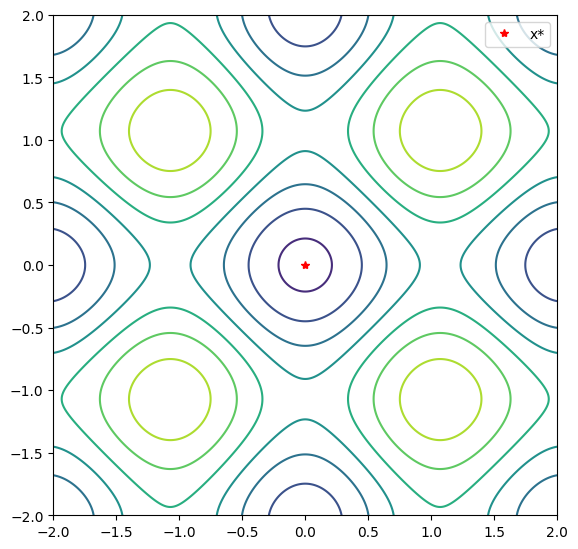

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from eggshell import egg_shell
import struct
import random
from ast import literal_eval
import os

# Terminal Printing colors
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'


# Make a plot of the eggshell function

x1_space = 1000
x2_space = 1000

x1_domain = np.linspace(-2.0,2.0,x1_space)
x2_domain = np.linspace(-2.0,2.0,x2_space)

egg_shell_domain = np.zeros((x1_space, x2_space))

# Evaluate each function at all points
for i in range(0,len(x1_domain)):

    for j in range(0,len(x2_domain)):

        egg_shell_domain[j][i] = egg_shell(np.array([x1_domain.item(i), x2_domain.item(j)]))


min_location = np.unravel_index(np.argmin(egg_shell_domain), egg_shell_domain.shape)


plt.figure(1, figsize=(6.5,6.5))
plt.contour(x1_domain,x2_domain,egg_shell_domain)
plt.plot(x1_domain[min_location[0]], x2_domain[min_location[1]], "*r")
plt.legend(['x*'])

2. Decide x precision and make objective function

In [15]:
def get_num_bits(min, max, precision):

    rhs = ((max - min) / precision) + 1

    m = np.log(rhs)/np.log(2)

    if m%1.0 != 0.0:

        m += 1

    return int(m)


print(get_num_bits(-10, 10, 0.00000001))

NUM_BITS = 32
MIN = -2.0
MAX = 2.0

PRECISION = (MAX - MIN) / (2**NUM_BITS - 1)

print(PRECISION)

obj_function = lambda x: egg_shell(x)

31
9.31322574832319e-10


3. Code the genetic algorithm cycles: Selection, Cross Breading, Mutation, and repetition

In [4]:
#Binary decode methods
def binary_decode(binary_val):

    x = MIN

    for i in range(0,len(binary_val)):

        if binary_val[i] == '1':

            x += 2**(len(binary_val)-1 - i) * PRECISION 

    return x


def get_real_x(genome):

    x_real  = []

    for gene in genome:

        val = binary_decode(gene)

        x_real.append(val)

    return x_real


def get_obj_funct(func, genome):

    x_real = get_real_x(genome)

    return func(x_real)


#Selection

# Implements roulette wheel 
def select_pairs(func, gene_pool):

    obj_metrics = []
    obj_functions =  []

    next_gen_parents = []

    # Extract objective function measures
    for i in gene_pool:

        objective = get_obj_funct(func,i)

        obj_metrics.append([i, objective])
        obj_functions.append(objective)
    
    # Get performance measure for routlette wheel
    f_low = min(obj_functions)
    f_hi = max(obj_functions)
    delta_f = 1.1*f_hi - 0.1*f_low

    total_F = 0

    for i in range(0, len(obj_metrics)):

        Fj = (-obj_metrics[i][1] + delta_f)/(max([1, delta_f - f_low]))

        assert Fj >= 0

        obj_metrics[i].append(Fj)

        total_F += Fj

    #Now sort the points according to F
    obj_metrics.sort(key = lambda x: x[2])

    sum_fj = 0
    #Now find Sj for each point
    for i in obj_metrics:

        sum_fj += i[2] # Add current fj to sum of fj

        i.append(sum_fj/total_F)

    # now roll the roulette wheel

    random.seed(obj_metrics[0][2]) # pick the first given objective value as a random seed

    for i in range(0, len(obj_metrics)):

        r = random.random()

        for j in range(0, len(obj_metrics)):

            if (r <= obj_metrics[j][3] and r > obj_metrics[j - 1][3]) or (r <= obj_metrics[j][3] and j == 0):
                
                next_gen_parents.append(obj_metrics[j][0])

    assert len(next_gen_parents) == len(gene_pool)

    return next_gen_parents


#Cross Over

#Given a two genome parents,
# will cross breed children. Uses single point methodology
def cross_breed(genome_1, genome_2):


    child_1 = []
    child_2 = []

    for i in range(0, len(genome_1)):

        setpoint = int(random.random() * len(genome_1[0]))

        if setpoint == 0:

            setpoint = 1

        chromezone_1 = genome_1[i][0: setpoint] + genome_2[i][setpoint: len(genome_2[i])]
        chromezone_2 = genome_2[i][0: setpoint] + genome_1[i][setpoint: len(genome_1[i])]

        assert len(chromezone_1) == len(chromezone_2) # Can't be having any genetic deformities here

        child_1.append(chromezone_1)
        child_2.append(chromezone_2)

    return child_1, child_2

# Given the full list of parents, will 
def cross_over(parents):

    next_gen = []

    for i in range(0,len(parents),2):

        p1 = parents[i]
        p2 = parents[i + 1]

        for child in cross_breed(p1,p2): next_gen.append(child)

    return next_gen

#Mutation

MUTATION_GAIN = 0.005
def mutate_genome(genome):

    p = MUTATION_GAIN # tunable mutation parameter

    out_gene = [] # the genome we return

    for chromosome in genome:

        new_chrome = ''
        
        for i in range(0, len(chromosome)):

            r = random.random() # see if we mutate

            if r <= p: # if we do add the opposite binary value

                gene = chromosome[i]

                if gene == '0':

                    new_chrome += '1'

                else:

                    new_chrome += '0'

            else: # if not, just add the next recurring gene to the chromosome

                new_chrome += chromosome[i]

        
        out_gene.append(new_chrome)

    
    return out_gene


#Given the population of points, will mutate all population
def mutate_population(population):

    new_population = []

    for genome in population: 

        new_genome = mutate_genome(genome)

        new_population.append(new_genome)

    return new_population


# Find minimum in a population
def get_population_minimum(func, population):

    x_star = None
    y_star = np.inf

    for member in population:

        eval = get_obj_funct(func, member)

        if eval < y_star:

            x_star = get_real_x(member)
            y_star = eval

    return x_star, y_star

4. Now that all helper methods are done, make the entire GA algorithm

In [5]:
VERBOSE = False

def GA_optimization(func, max_itr, size):

    # Ensure even population size:
    assert size >= 4

    if size % 2 != 0:

        size += 1

    # Generate initial population
    population = []
    
    for i in range(0, size):

        x1 = ''
        x2 = ''

        for i in range(0,NUM_BITS):

            x1 += str(round(random.random()))
            x2 += str(round(random.random()))

        population.append([x1,x2])


    # Simulate generational evolution
    k = 0
    while k < max_itr:

        parents = select_pairs(func,population)

        new_population = cross_over(parents)

        new_population = mutate_population(new_population)

        population = new_population

        k += 1

        if VERBOSE:

            percentage_completion = round(k/max_itr * 100, 1)
            print(f'GEN: {k} | [' + bcolors.OKGREEN + f'{percentage_completion}%' + bcolors.ENDC +']')

    
    # return the minimum element
    final_population = []
    for i in population:

        final_population.append(get_real_x(i))

    result = list(get_population_minimum(func,population))

    result.append(final_population)

    return result
    

5. Now try the genetic algorithm out on the eggshell funcion

In [16]:
result = GA_optimization(egg_shell,5000,100)

x* = [0.00010304199534073508, -0.0005154446699925338]
minimum is: -1.9999987290162797


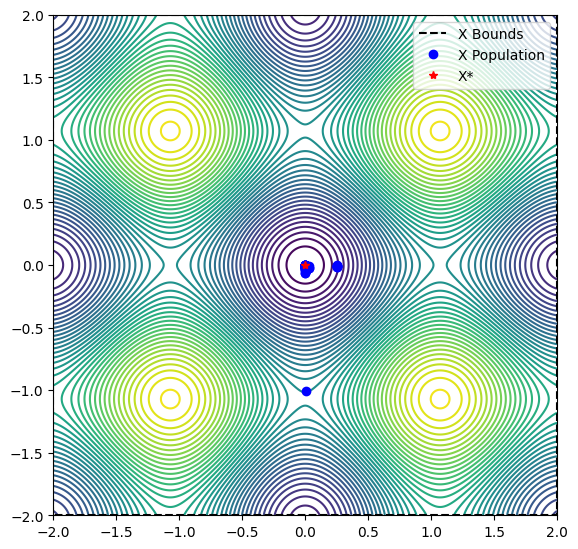

In [17]:
plt.figure(1, figsize=(6.5,6.5))
plt.contour(x1_domain,x2_domain,egg_shell_domain, 50)
plt.plot([MIN,MIN, MAX, MAX, MIN],[MIN,MAX, MAX, MIN, MIN],'k--')

x_vals = []
y_vals = []

for point in result[2]:

    x_vals.append(point[0])
    y_vals.append(point[1])

plt.plot(x_vals,y_vals,'ob')

plt.plot(x1_domain[min_location[0]], x2_domain[min_location[1]], "*r")

plt.legend(['X Bounds', 'X Population', 'X*'])


print(f'x* = {result[0]}')
print(f'minimum is: {result[1]}')

Here we see that the GA effectively converged onto the minimum of the eggshell problem. Due to genetic diversity, a few stragglers remain outside the minimum.

6. Now explore the effects of population size on convergence

In [8]:
# Make a version of the GA that keeps track of extra metrics

VERBOSE = False

def GA_optimization_convergence(func, max_itr, size):

    x1_stars = []
    x2_stars = []
    y_stars = []

    # Ensure even population size:
    assert size >= 4

    if size % 2 != 0:

        size += 1

    # Generate initial population
    population = []
    
    for i in range(0, size):

        x1 = ''
        x2 = ''

        for i in range(0,NUM_BITS):

            x1 += str(round(random.random()))
            x2 += str(round(random.random()))

        population.append([x1,x2])


    # Simulate generational evolution
    k = 0
    while k < max_itr:

        parents = select_pairs(func,population)

        new_population = cross_over(parents)

        new_population = mutate_population(new_population)

        population = new_population

        x_star, y_star = get_population_minimum(func, population)

        x1_stars.append(x_star[0])
        x2_stars.append(x_star[1])
        y_stars.append(y_star)

        k += 1

        if VERBOSE:

            percentage_completion = round(k/max_itr * 100, 1)
            print(f'GEN: {k} | [' + bcolors.OKGREEN + f'{percentage_completion}%' + bcolors.ENDC +']')

    
    # return the minimum element
    final_population = []
    for i in population:

        final_population.append(get_real_x(i))

    result = list(get_population_minimum(func,population))

    result.append(final_population)

    result.append(x1_stars)
    result.append(x2_stars)
    result.append(y_stars)

    return result


# Now gather convergence data

pop_10 = GA_optimization_convergence(egg_shell,1000,10)
pop_20 = GA_optimization_convergence(egg_shell,1000,20)
pop_100 = GA_optimization_convergence(egg_shell,1000,100)
pop_200 = GA_optimization_convergence(egg_shell,1000,200)

GEN: 1 | [0.1%]
GEN: 2 | [0.2%]
GEN: 3 | [0.3%]
GEN: 4 | [0.4%]
GEN: 5 | [0.5%]
GEN: 6 | [0.6%]
GEN: 7 | [0.7%]
GEN: 8 | [0.8%]
GEN: 9 | [0.9%]
GEN: 10 | [1.0%]
GEN: 11 | [1.1%]
GEN: 12 | [1.2%]
GEN: 13 | [1.3%]
GEN: 14 | [1.4%]
GEN: 15 | [1.5%]
GEN: 16 | [1.6%]
GEN: 17 | [1.7%]
GEN: 18 | [1.8%]
GEN: 19 | [1.9%]
GEN: 20 | [2.0%]
GEN: 21 | [2.1%]
GEN: 22 | [2.2%]
GEN: 23 | [2.3%]
GEN: 24 | [2.4%]
GEN: 25 | [2.5%]
GEN: 26 | [2.6%]
GEN: 27 | [2.7%]
GEN: 28 | [2.8%]
GEN: 29 | [2.9%]
GEN: 30 | [3.0%]
GEN: 31 | [3.1%]
GEN: 32 | [3.2%]
GEN: 33 | [3.3%]
GEN: 34 | [3.4%]
GEN: 35 | [3.5%]
GEN: 36 | [3.6%]
GEN: 37 | [3.7%]
GEN: 38 | [3.8%]
GEN: 39 | [3.9%]
GEN: 40 | [4.0%]
GEN: 41 | [4.1%]
GEN: 42 | [4.2%]
GEN: 43 | [4.3%]
GEN: 44 | [4.4%]
GEN: 45 | [4.5%]
GEN: 46 | [4.6%]
GEN: 47 | [4.7%]
GEN: 48 | [4.8%]
GEN: 49 | [4.9%]
GEN: 50 | [5.0%]
GEN: 51 | [5.1%]
GEN: 52 | [5.2%]
GEN: 53 | [5.3%]
GEN: 54 | [5.4%]
GEN: 55 | [5.5%]
GEN: 56 | [5.6%]
GEN: 57 | [5.7%]
GEN: 58 | [5.8%]
GEN: 59 | [5.9%]
GEN: 6

Text(0.5, 1.0, 'Convergence of Y Values for GA')

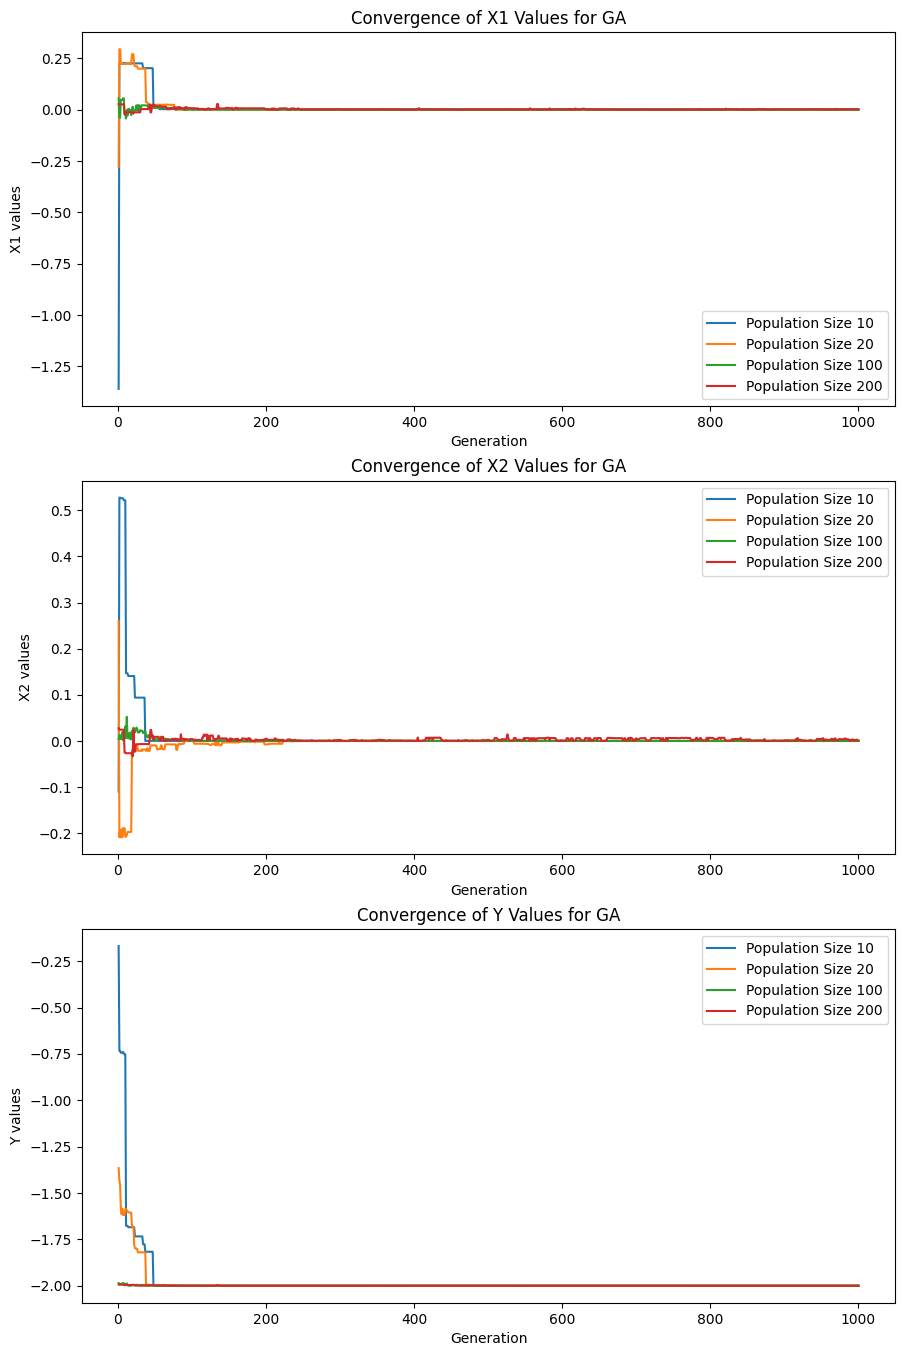

In [9]:
x1_stars_10 = pop_10[3]
x2_stars_10 = pop_10[4]
y_stars_10 = pop_10[5]

x1_stars_20 = pop_20[3]
x2_stars_20 = pop_20[4]
y_stars_20 = pop_20[5]

x1_stars_100 = pop_100[3]
x2_stars_100 = pop_100[4]
y_stars_100 = pop_100[5]

x1_stars_200 = pop_200[3]
x2_stars_200 = pop_200[4]
y_stars_200 = pop_200[5]


domain = np.linspace(1,1000,1000)
zero = np.zeros_like(domain)
y_real = np.ones_like(domain)

plt.figure(2, figsize=(10.5, 16.5))

plt.subplot(3,1,1)
plt.plot(domain,x1_stars_10)
plt.plot(domain,x1_stars_20)
plt.plot(domain,x1_stars_100)
plt.plot(domain,x1_stars_200)
plt.legend(['Population Size 10', 'Population Size 20', 'Population Size 100', 'Population Size 200'])
plt.xlabel('Generation')
plt.ylabel('X1 values')
plt.title('Convergence of X1 Values for GA')

plt.subplot(3,1,2)
plt.plot(domain,x2_stars_10)
plt.plot(domain,x2_stars_20)
plt.plot(domain,x2_stars_100)
plt.plot(domain,x2_stars_200)
plt.legend(['Population Size 10', 'Population Size 20', 'Population Size 100', 'Population Size 200'])
plt.xlabel('Generation')
plt.ylabel('X2 values')
plt.title('Convergence of X2 Values for GA')

plt.subplot(3,1,3)
plt.plot(domain,y_stars_10)
plt.plot(domain,y_stars_20)
plt.plot(domain,y_stars_100)
plt.plot(domain,y_stars_200)
plt.legend(['Population Size 10', 'Population Size 20', 'Population Size 100', 'Population Size 200'])
plt.xlabel('Generation')
plt.ylabel('Y values')
plt.title('Convergence of Y Values for GA')


These graphs show that an overall increase in genetic diveristy usually correlated to quicker convergence. However, it can be noticed that a 200 members, the convergence begins to slow down as more genetic noise is introduced.

7. Examine effects of Number of Generations

Text(0.5, 1.0, 'Convergence of Y Values for GA')

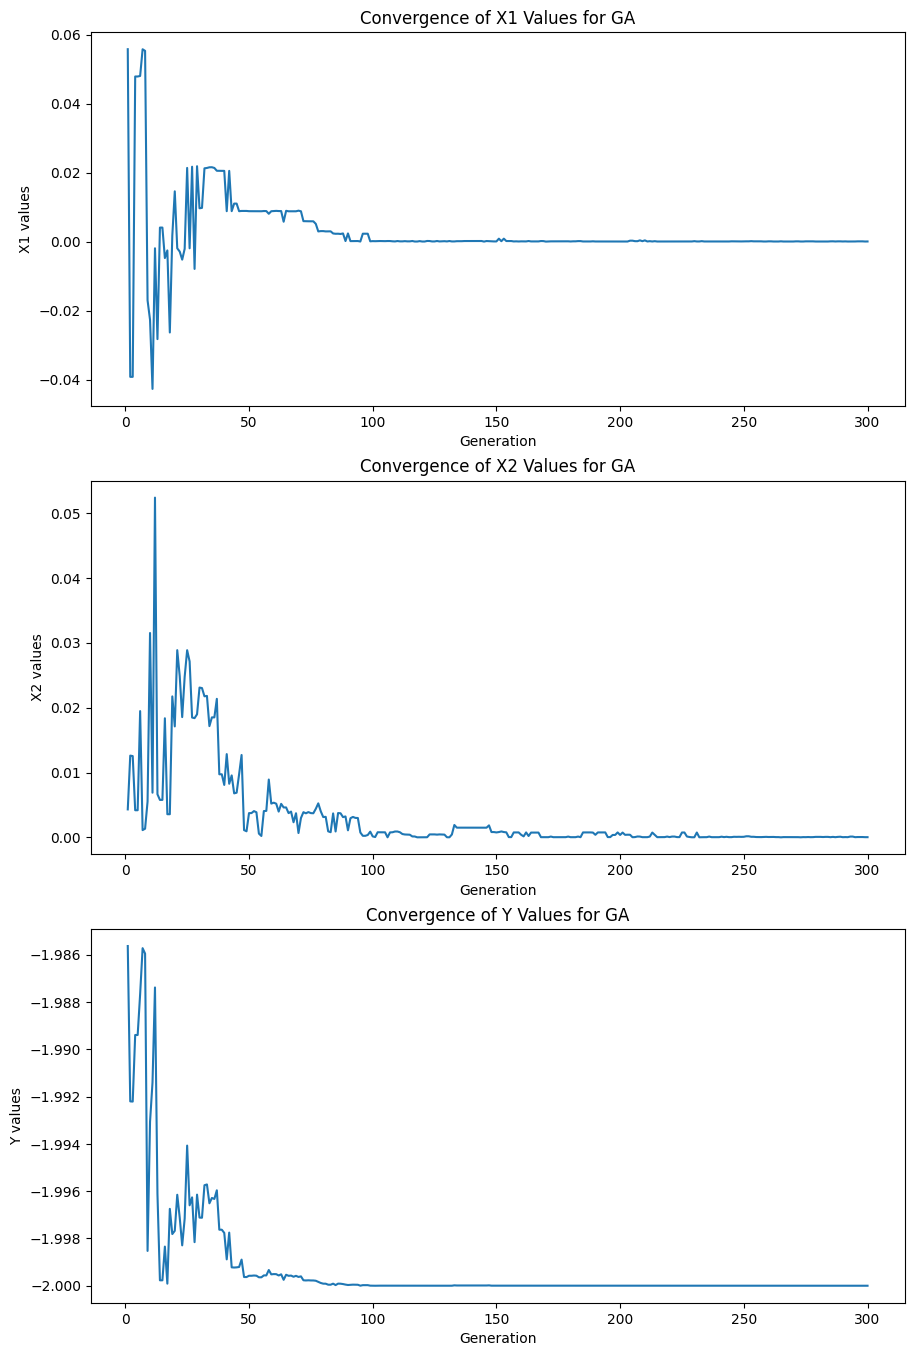

In [10]:
plt.figure(2, figsize=(10.5, 16.5))

plt.subplot(3,1,1)
plt.plot(domain[0:300],x1_stars_100[0:300])
plt.xlabel('Generation')
plt.ylabel('X1 values')
plt.title('Convergence of X1 Values for GA')

plt.subplot(3,1,2)
plt.plot(domain[0:300],x2_stars_100[0:300])
plt.xlabel('Generation')
plt.ylabel('X2 values')
plt.title('Convergence of X2 Values for GA')

plt.subplot(3,1,3)
plt.plot(domain[0:300],y_stars_100[0:300])
plt.xlabel('Generation')
plt.ylabel('Y values')
plt.title('Convergence of Y Values for GA')


This graph shows that as number of generations increases, x start converges exponentially. 

8. Investigate Convergence based on Genetic mutation gain

In [11]:
VERBOSE = False

MUTATION_GAIN = 0.5
pop_5 = GA_optimization_convergence(egg_shell,1000,100)
MUTATION_GAIN = 0.05
pop_05 = GA_optimization_convergence(egg_shell,1000,100)
MUTATION_GAIN = 0.005
pop_005 = GA_optimization_convergence(egg_shell,1000,100)

Text(0.5, 1.0, 'Convergence of Y Values for GA')

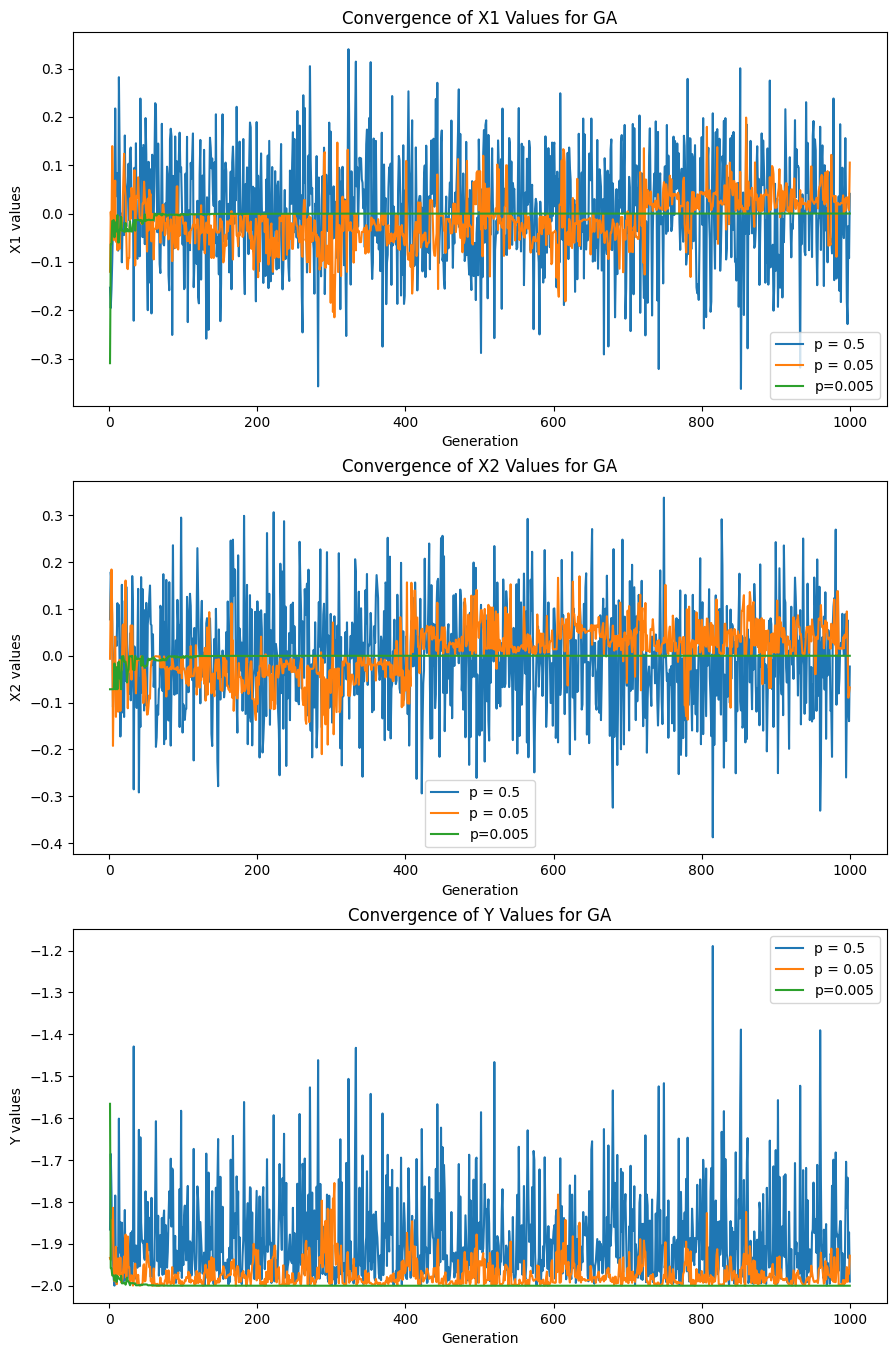

In [12]:
x1_stars_5 = pop_5[3]
x2_stars_5 = pop_5[4]
y_stars_5 = pop_5[5]

x1_stars_05 = pop_05[3]
x2_stars_05 = pop_05[4]
y_stars_05 = pop_05[5]

x1_stars_005 = pop_005[3]
x2_stars_005 = pop_005[4]
y_stars_005 = pop_005[5]

domain = np.linspace(1,1000,1000)
zero = np.zeros_like(domain)
y_real = np.ones_like(domain)

plt.figure(2, figsize=(10.5, 16.5))

plt.subplot(3,1,1)
plt.plot(domain,x1_stars_5)
plt.plot(domain,x1_stars_05)
plt.plot(domain,x1_stars_005)
plt.legend(['p = 0.5', 'p = 0.05', 'p=0.005'])
plt.xlabel('Generation')
plt.ylabel('X1 values')
plt.title('Convergence of X1 Values for GA')

plt.subplot(3,1,2)
plt.plot(domain,x2_stars_5)
plt.plot(domain,x2_stars_05)
plt.plot(domain,x2_stars_005)
plt.legend(['p = 0.5', 'p = 0.05', 'p=0.005'])
plt.xlabel('Generation')
plt.ylabel('X2 values')
plt.title('Convergence of X2 Values for GA')

plt.subplot(3,1,3)
plt.plot(domain,y_stars_5)
plt.plot(domain,y_stars_05)
plt.plot(domain,y_stars_005)
plt.legend(['p = 0.5', 'p = 0.05', 'p=0.005'])
plt.xlabel('Generation')
plt.ylabel('Y values')
plt.title('Convergence of Y Values for GA')


As shown in the graph, increasing mutation probabilty has the effect of adding noise to the system. While some noise is good for getting out of ruts and weird solutions, too much can delay or prevent convergence. 